In [1]:
#!pip install spectral

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

#from spectral import imshow, view_cube
#import spectral.io.envi as envi


## Inforamções aleatórias

usar so antigeno, controle e interferencia (outras coisas que nao é o antigeno)

coluna 1 e 2: coordenada da imagem
coluna 3: comprimento de onda
coluna 4: intensidade do elemento

plotar intensidade x comprimento: espectro


para cada pixel tem um array que é o espectro. E cada espectro tem 1014 comprimento de ondas.

se parar no comprimento de onda e olha os dados (os pixels) vemos a imagem


cada espectro tem 1014 linhas. com 441 espectros (21 linhas x 21 colunas)


olhar para comprimento de onda de onde esta o pico.

espectro medio

o objeto de dado é o cubo. dentro daquele cubo temos que saber quais atributos são importantes

ver imagem basta fixar os espectros e percorrer as coordenadas 

1079, cm^-1, pico de tudo

### Lendo os arquivos do diretório

In [2]:
antigenPath = 'dados/sers/antigen'
controlPath = 'dados/sers/control'
interferingPath = 'dados/sers/interfering'



def validate_data_shape(data, expected_num_spectra, points_per_spectrum, file_name):
    if not data.shape[0] == expected_num_spectra * points_per_spectrum:
        raise Exception(
            'Error in file {}. Number of spectra ({}) unexpected.'.format(file_name, data.shape[0])
        )


def process_copy(data, spec_number, points_per_spectrum, is_initial_spec, previous_raman_shift, file_name):
    spec_start = spec_number * points_per_spectrum
    spec_end = (spec_number + 1) * points_per_spectrum
    position_x = int(data[spec_start, 0])
    position_y = int(data[spec_start, 1])

    if is_initial_spec:
        current_raman_shift = data[spec_start:spec_end, -2]
        is_initial_spec = False
    else:
        if not np.array_equal(data[spec_start:spec_end, -2], previous_raman_shift):
            raise Exception(
                'Error in file {}, spec number {}. Raman Shift axis is different.'.format(file_name, spec_number)
            )
        else:
            current_raman_shift = data[spec_start:spec_end, -2]

    return spec_start, spec_end, position_x, position_y, current_raman_shift, is_initial_spec


def create_dataframe_from_files(file_list):
    spectra_data = []
    positions_data = []
    is_initial_spec = True
    num_spectra = 441
    points_per_spectrum = 1014
    map_counter = 0
    previous_raman_shift = None

    for file_name in file_list:
        data = np.loadtxt(file_name, delimiter="\t")
        validate_data_shape(data, num_spectra, points_per_spectrum, file_name)

        num_specs = data.shape[0] / points_per_spectrum
        print(file_name, num_specs)

        for spec_number in range(int(num_specs)):
            spec_start, spec_end, position_x, position_y, previous_raman_shift, is_initial_spec = process_copy(
                data, spec_number, points_per_spectrum, is_initial_spec, previous_raman_shift, file_name
            )

            spectra_data.append(data[spec_start:spec_end, -1])
            positions_data.append([position_x, position_y, spec_number, map_counter])

        map_counter += 1

    df_spectra = pd.DataFrame(data=spectra_data, columns=data[spec_start:spec_end, -2])
    df_positions = pd.DataFrame(data=positions_data, columns=['x', 'y', 'spec_number', 'map'])
    df_combined = pd.concat([df_spectra, df_positions], axis=1)
    df_combined = df_combined.sort_values(by=['map', 'spec_number'], ignore_index=True)
    return df_combined

def create_datasets(antigen_path, control_path, interfering_path):
    antigen_files = next(os.walk(antigen_path), (None, None, []))[2]
    control_files = next(os.walk(control_path), (None, None, []))[2]
    interfering_files = next(os.walk(interfering_path), (None, None, []))[2]

    antigen_data = create_dataframe_from_files([os.path.join(antigen_path, file_name) for file_name in antigen_files])
    control_data = create_dataframe_from_files([os.path.join(control_path, file_name) for file_name in control_files])
    interfering_data = create_dataframe_from_files([os.path.join(interfering_path, file_name) for file_name in interfering_files])

    return antigen_data, control_data, interfering_data


def merge_datasets(antigen_data, control_data, interfering_data):
    # Add a new column with values 0 for control, 1 for antigen, and 2 for interfering
    antigen_data['target'] = 1
    control_data['target'] = 0
    interfering_data['target'] = 2

    # Concatenate the three dataframes vertically
    merged_data = pd.concat([antigen_data, control_data, interfering_data], axis=0)
    merged_data = merged_data.reset_index(drop = True)

    return merged_data

antigen_data, control_data, interfering_data = create_datasets(antigenPath, controlPath, interferingPath)
raw_data = merge_datasets(antigen_data, control_data, interfering_data)
#raw_data = create_datasets(antigenPath, controlPath, interferingPath)
raw_data

dados/sers/antigen\antigeno1.txt 441.0
dados/sers/antigen\antigeno10.txt 441.0
dados/sers/antigen\antigeno11.txt 441.0
dados/sers/antigen\antigeno12.txt 441.0
dados/sers/antigen\antigeno13.txt 441.0
dados/sers/antigen\antigeno14.txt 441.0
dados/sers/antigen\antigeno15.txt 441.0
dados/sers/antigen\antigeno16.txt 441.0
dados/sers/antigen\antigeno2.txt 441.0
dados/sers/antigen\antigeno3.txt 441.0
dados/sers/antigen\antigeno4.txt 441.0
dados/sers/antigen\antigeno5.txt 441.0
dados/sers/antigen\antigeno6.txt 441.0
dados/sers/antigen\antigeno7.txt 441.0
dados/sers/antigen\antigeno8.txt 441.0
dados/sers/antigen\antigeno9.txt 441.0
dados/sers/control\controle1.txt 441.0
dados/sers/control\controle10.txt 441.0
dados/sers/control\controle11.txt 441.0
dados/sers/control\controle12.txt 441.0
dados/sers/control\controle13.txt 441.0
dados/sers/control\controle14.txt 441.0
dados/sers/control\controle15.txt 441.0
dados/sers/control\controle16.txt 441.0
dados/sers/control\controle17.txt 441.0
dados/sers

,1611.19,1610.19,1609.18,1608.18,1607.17,1606.17,1605.16,1604.16,1603.15,1602.14,...,476.105,474.84,473.574,472.308,471.042,x,y,spec_number,map,target
0,1971.64,2113.54,2145.43,2147.46,2134.56,2268.41,2310.19,2478.76,2607.48,2793.30,...,855.849,879.351,883.085,853.242,892.524,-10,-10,0,0,1
1,2061.26,2096.11,2093.17,2199.71,2214.17,2273.38,2404.69,2446.44,2649.73,2818.15,...,873.638,865.518,875.183,872.993,904.372,-10,-9,1,0,1
2,2043.83,2036.36,2080.72,2149.95,2176.85,2328.10,2327.60,2516.05,2649.73,2778.39,...,828.177,887.255,902.841,872.993,849.083,-10,-8,2,0,1
3,2001.51,2041.34,2068.28,2102.67,2216.65,2233.59,2322.63,2545.88,2595.05,2828.09,...,855.849,859.590,867.281,916.445,922.143,-10,-7,3,0,1
4,2031.38,2098.60,2120.55,2192.25,2236.56,2365.41,2302.73,2458.87,2652.22,2808.21,...,897.356,907.016,918.646,928.295,876.727,-10,-6,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20281,1540.96,1687.84,1754.68,1716.97,1826.07,1738.62,1927.23,1894.50,1983.57,2154.62,...,679.935,650.127,673.674,647.832,649.647,10,6,436,9,2
20282,1610.67,1635.56,1692.45,1712.00,1763.87,1870.44,1780.51,1929.30,1963.69,2162.07,...,658.193,695.576,681.576,635.981,657.545,10,7,437,9,2
20283,1690.33,1672.90,1699.92,1754.30,1796.21,1882.88,1932.21,1966.60,2025.83,2109.89,...,636.451,661.983,663.796,709.060,649.647,10,8,438,9,2
20284,1700.29,1692.82,1687.48,1684.62,1726.55,1798.31,1894.91,1929.30,2035.77,2157.10,...,677.959,669.887,661.820,651.782,681.241,10,9,439,9,2


In [3]:
def calculate_difference(df_out, out_1):
    diff = 0.0
    n_spec = len(out_1)

    for i in range(n_spec):
        spec_exp = np.array(out_1[i])
        spec_raw = df_out.iloc[i, :-5].values
        diff += np.sum(spec_exp - spec_raw)

    return diff


def count_per_class_and_map(df_out):
    count = df_out.groupby(['target', 'map'])['map'].count()
    return count


# Example usage:
count = count_per_class_and_map(raw_data)
count

target  map
0       0      441
        1      441
        2      441
        3      441
        4      441
        5      441
        6      441
        7      441
        8      441
        9      441
        10     441
        11     441
        12     441
        13     441
        14     441
        15     441
        16     441
        17     441
        18     441
        19     441
1       0      441
        1      441
        2      441
        3      441
        4      441
        5      441
        6      441
        7      441
        8      441
        9      441
        10     441
        11     441
        12     441
        13     441
        14     441
        15     441
2       0      441
        1      441
        2      441
        3      441
        4      441
        5      441
        6      441
        7      441
        8      441
        9      441
Name: map, dtype: int64

In [4]:
def countValues(array):
    return pd.DataFrame(array.value_counts())

targets = raw_data.iloc[:,-1]
countValues(targets)

,target
0,8820
1,7056
2,4410


In [5]:
columns = raw_data.columns
countValues(columns)

,0
1611.19,1
871.124,1
886.279,1
885.115,1
883.951,1
...,...
1252.82,1
1251.74,1
1250.66,1
1249.58,1


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20286 entries, 0 to 20285
Columns: 1019 entries, 1611.19 to target
dtypes: float64(1014), int64(5)
memory usage: 157.7 MB


In [7]:
## 21 x 21 x 1014 = 441 (number of waves) x 1014 (lenght of a wave)
def filter_dataframe(df, condition_column, condition_value):
    filtered_df = df[df[condition_column] != condition_value]
    #remaining_df = df[df[condition_column] == condition_value]
    return filtered_df, df

raw_data, remaining_raw_data = filter_dataframe(raw_data, 'target', 2)
raw_data

,1611.19,1610.19,1609.18,1608.18,1607.17,1606.17,1605.16,1604.16,1603.15,1602.14,...,476.105,474.84,473.574,472.308,471.042,x,y,spec_number,map,target
0,1971.64,2113.54,2145.43,2147.46,2134.56,2268.41,2310.19,2478.76,2607.48,2793.30,...,855.849,879.351,883.085,853.242,892.524,-10,-10,0,0,1
1,2061.26,2096.11,2093.17,2199.71,2214.17,2273.38,2404.69,2446.44,2649.73,2818.15,...,873.638,865.518,875.183,872.993,904.372,-10,-9,1,0,1
2,2043.83,2036.36,2080.72,2149.95,2176.85,2328.10,2327.60,2516.05,2649.73,2778.39,...,828.177,887.255,902.841,872.993,849.083,-10,-8,2,0,1
3,2001.51,2041.34,2068.28,2102.67,2216.65,2233.59,2322.63,2545.88,2595.05,2828.09,...,855.849,859.590,867.281,916.445,922.143,-10,-7,3,0,1
4,2031.38,2098.60,2120.55,2192.25,2236.56,2365.41,2302.73,2458.87,2652.22,2808.21,...,897.356,907.016,918.646,928.295,876.727,-10,-6,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15871,2320.16,2412.27,2454.06,2525.69,2557.49,2499.73,2722.99,2841.74,3037.50,3265.48,...,1081.180,1027.560,1084.590,1098.150,1099.860,10,6,436,19,0
15872,2392.35,2447.12,2481.44,2528.18,2599.78,2636.53,2747.86,2881.52,3062.36,3307.72,...,1087.110,1074.980,1078.670,1165.310,1147.250,10,7,437,19,0
15873,2367.46,2374.93,2464.01,2627.71,2559.97,2671.35,2805.06,2881.52,3052.41,3258.02,...,1065.360,1106.600,1064.840,1113.950,1131.450,10,8,438,19,0
15874,2367.46,2442.14,2526.24,2538.13,2629.63,2614.14,2785.16,2916.33,3022.59,3287.84,...,1083.150,1041.390,1070.770,1110.000,1168.970,10,9,439,19,0


# Data Visualization

## Signal visualization

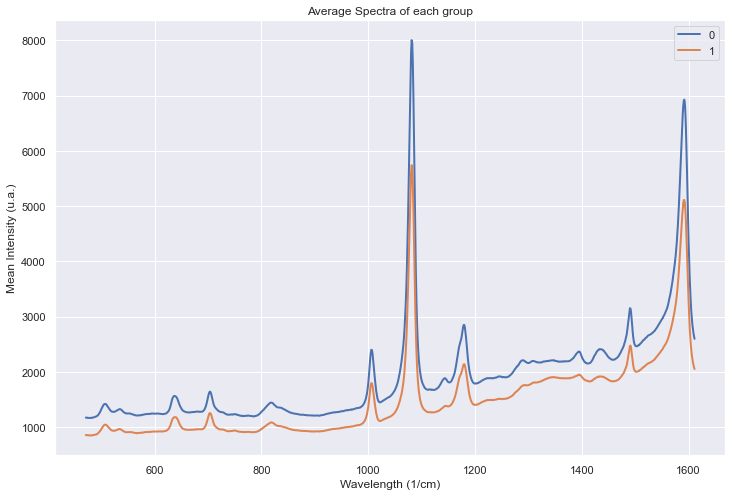

In [8]:
def plotParallelCoordinates(df, title, xlabel, ylabel, target = 'target', colors = ['red', 'blue', 'green']):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,15))
    new_df = df.copy()
    pd.plotting.parallel_coordinates(frame = new_df, class_column = target, ax = ax, color = colors)
    ax.set(title = title,
           xlabel = xlabel,
           ylabel = ylabel)
    plt.xticks(rotation = 45, fontsize = 10)
    #ax.set_xticklabels(rotation = (45), fontsize = 10, va='bottom', ha='left')
    plt.show()



def plotSersSignal(dataframe):
    sns.set(style="darkgrid")
    fig, ax = plt.subplots(figsize=(16,12))

    target_column = "target"
    columns = dataframe.columns.to_list()
    columns.remove(target_column)

    dataframe_melted = dataframe.melt(id_vars=target_column, value_vars=columns, var_name="Wavelength (1/cm)", value_name="Intensity (u.a.)")
    sns.lineplot(data=dataframe_melted, x="Wavelength (1/cm)", y="Intensity (u.a.)", hue=target_column, markers=True)

    plt.xlabel('Wavelength (1/cm)')
    plt.ylabel('Intensity (u.a.)')
    plt.title('SERS Signal')
    plt.legend()
    plt.xticks(rotation=45)  # Set x-axis ticks to go from 50 to 50 values
    #plt.tight_layout()
    plt.show()
    
def plotAverageSpectra(dataframe):
    # Exclude the "target" column
    data = dataframe.drop("target", axis=1)
    
    # Group the dataframe by the "target" column
    grouped_data = dataframe.groupby("target")
    
    # Set up the plot
    sns.set(style="darkgrid")
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Get the column names for plotting
    columns = data.columns
    
    # Iterate over each group
    for group_name, group_data in grouped_data:
        # Calculate the average of each column within the group
        average_spectrum = group_data.iloc[:, :-1].median(axis=0)        
        # Plot the average spectrum as a line graph
        sns.lineplot(x=columns, y=average_spectrum, label=group_name, linewidth=2)
    
    # Set the x and y labels, title, and legend
    plt.xlabel('Wavelength (1/cm)')
    plt.ylabel('Mean Intensity (u.a.)')
    plt.title('Average Spectra of each group')
    plt.legend()
    
    # Display the plot
    plt.show()

def plotMultipleSersSignals(dataframe):
    sns.set(style="darkgrid")
    fig, ax = plt.subplots(figsize=(12, 8))

    for index, row in dataframe.iterrows():
        signal = row.drop("target")  # Exclude the "target" column
        sns.lineplot(x=signal.columns, y=signal.values, label=row["target"], linewidth=2)

    plt.xlabel('Points')
    plt.ylabel('Intensity')
    plt.title('Multiple SERS Signals')
    plt.legend(title="Target")
    plt.show()


## fazer essa funcao com uma power analysis!!!!!!! - tem resultado significativoe diminui tempo
X = raw_data.drop(['x','y','spec_number','map'], axis = 1)
#plotMultipleSersSignals(X)
plotAverageSpectra(X)

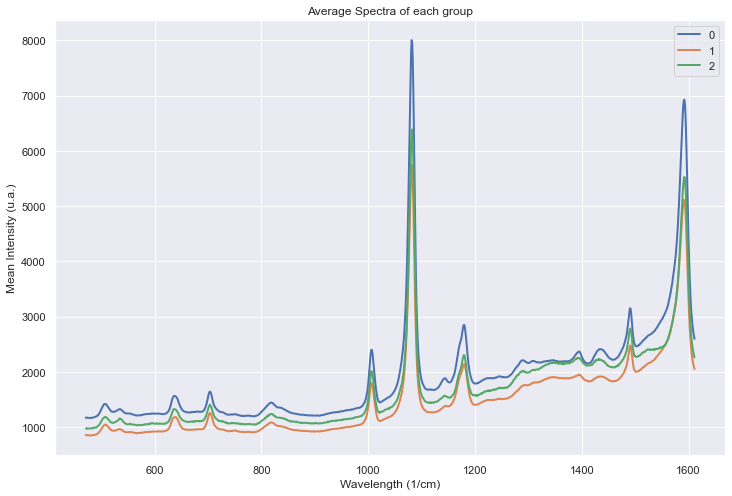

In [9]:
X2 = remaining_raw_data.drop(['x','y','spec_number','map'], axis = 1)
plotAverageSpectra(X2)

## Map visualization

In [10]:
import math
from matplotlib.ticker import FuncFormatter

def plotSERSMaps(df, dim, target_class):
    unique_maps = getUniqueMaps(df, target_class)
    n_rows, n_cols = calculateGridSize(unique_maps)
    figsize = calculateFigSize(n_rows)
    fig, axes = createSubplots(n_rows, n_cols, figsize)
    
    for i, mp in enumerate(unique_maps):
        ax = axes[i]
        subset = getSubset(df, target_class, mp)
        
        if subset.empty:
            hideSubplot(ax)
            continue
        
        mi = calculateMeanIntensity(subset, dim)
        im = plotIntensityMap(ax, mi, target_class, mp)
        addColorbar(im, ax)
        setTickLabels(ax)
    
    hideExtraSubplots(len(unique_maps), n_rows, n_cols, axes)
    setLayout()
    showPlot()


def getUniqueMaps(df, target_class):
    return df.loc[df['target'] == target_class, 'map'].unique()


def calculateGridSize(unique_maps):
    n_rows = math.ceil(len(unique_maps) / 2)
    n_cols = 2
    return n_rows, n_cols


def calculateFigSize(n_rows):
    return (10, 5 * n_rows)


def createSubplots(n_rows, n_cols, figsize):
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    axes = axes.flatten()
    return fig, axes


def getSubset(df, target_class, mp):
    return df.loc[(df['target'] == target_class) & (df['map'] == mp)]


def hideSubplot(ax):
    ax.axis('off')


def calculateMeanIntensity(subset, dim):
    return subset.iloc[:, :-5].mean(axis=1).values.reshape(dim, dim)


def plotIntensityMap(ax, mi, target_class, mp):
    im = ax.imshow(mi)
    ax.set_title(f'class={target_class}, map={mp}')
    return im


def addColorbar(im, ax):
    cb = plt.colorbar(im, shrink=0.825, ax=ax)
    cb.ax.set_yticklabels(cb.ax.get_yticks(), fontsize=12)


def setTickLabels(ax):
    ax.set_xticklabels(ax.get_xticks(), size=10)
    ax.set_yticklabels(ax.get_yticks(), size=10)
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))


def hideExtraSubplots(num_maps, n_rows, n_cols, axes):
    for j in range(num_maps, n_rows * n_cols):
        axes[j].axis('off')


def setLayout():
    plt.tight_layout()


def showPlot():
    plt.show()

    
dim = 21  # Define the number of pixels per row/column
#plotSERSMaps(raw_data, dim, 0)


In [11]:
#plotSERSMaps(raw_data, dim, 1)

## Box plots

In [12]:
def boxPlot(df, hue):
    n_rows = (len(df.columns) + 1) // 2  # Number of rows
    n_cols = 2  # Number of columns
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows))
    for ax, col in zip(axes.flat, df.columns):
        sns.boxplot(data=df, x=col, y=hue, ax=ax)
        ax.set_title(f'Boxplot of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel(hue)
    plt.tight_layout()
    plt.show()

def plotGroupedBoxplot(signal):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create a list to hold the data for each column
    data = [signal.iloc[:, i] for i in range(signal.shape[1])]
    
    # Generate positions for the boxplots along the x-axis
    positions = np.arange(1, signal.shape[1] + 1)
    
    # Create the grouped boxplot
    ax.boxplot(data, positions=positions, patch_artist=True, medianprops={'color': 'black'})
    
    # Set the x-axis labels
    ax.set_xticks(positions)
    ax.set_xticklabels(signal.columns)
    ax.set_xlabel('Columns')
    
    # Set the y-axis label
    ax.set_ylabel('Values')
    
    # Set the plot title
    ax.set_title('Grouped Boxplot of Signal Columns')
    
    # Adjust the layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()


def plotBoxplotEveryXColumns(dataframe, x):
    num_cols = dataframe.shape[1]
    num_plots = num_cols // x + 1 if num_cols % x != 0 else num_cols // x

    fig, axes = plt.subplots(nrows=num_plots, figsize=(12, 6*num_plots))

    for i in range(num_plots):
        start_idx = i * x
        end_idx = start_idx + x
        subset = dataframe.iloc[:, start_idx:end_idx]
        
        ax = axes[i] if num_plots > 1 else axes
        ax.boxplot(subset.values, patch_artist=True)
        ax.set_xticklabels(subset.columns, rotation=45)
        ax.set_xlabel('Columns')
        ax.set_ylabel('Value')
        ax.set_title(f'Boxplot of Columns {start_idx+1} to {end_idx}')

    plt.tight_layout()
    plt.show()

#boxPlot(X, 'target')
signals = X.drop(['target'], axis = 1)
#plotBoxplotEveryXColumns(signals, 15)

## Histograms

In [13]:
def histPlot(df, hue):
    n_rows = (len(df.columns) + 1) // 2  # Number of rows
    n_cols = 2  # Number of columns
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows))
    for ax, col in zip(axes.flat, df.columns):
        #print(df[col].value_counts())
        sns.histplot(data=df, x=col, hue = hue, kde=True, ax=ax)
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

#histPlot(X, 'target')

# Statistics

## From rows

In [14]:
from scipy.stats import kurtosis, skew

def extractingStatistics(df):

    stats_df = pd.DataFrame(columns = ['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurtosis'])

    for i in range(len(df)):
        sample = df.iloc[i].values
        stats_df.loc[i] = [np.mean(sample), 
                           np.std(sample),
                           np.min(sample),
                           np.quantile(sample, 0.25),
                           np.quantile(sample, 0.5),
                           np.quantile(sample, 0.75),
                           np.max(sample),
                           skew(list(sample)),
                           kurtosis(list(sample))]
    return stats_df

stats_data = extractingStatistics(X)
stats_data['target'] = X['target']
stats_data

,mean,std,min,25%,50%,75%,max,skew,kurtosis,target
0,1525.942305,731.203920,1.0,982.6440,1323.24,1854.020,5718.68,2.405472,8.134007,1
1,1536.845304,741.511550,1.0,993.5375,1324.24,1871.335,5808.10,2.442026,8.397045,1
2,1538.924767,742.823801,1.0,996.2905,1326.28,1874.365,5886.35,2.444430,8.389582,1
3,1553.398834,745.163981,1.0,1006.5750,1342.23,1885.670,5710.68,2.434829,8.306814,1
4,1561.859051,744.877066,1.0,1016.7050,1357.91,1895.205,5762.47,2.444771,8.366095,1
...,...,...,...,...,...,...,...,...,...,...
15871,1802.145803,886.940527,0.0,1162.8300,1626.19,2112.790,6908.02,2.567742,8.921995,0
15872,1816.804552,893.586671,0.0,1174.2600,1646.88,2129.795,6811.89,2.553695,8.823714,0
15873,1824.229005,899.784504,0.0,1174.4900,1661.04,2138.085,6970.62,2.558095,8.891431,0
15874,1848.437724,910.436067,0.0,1191.8400,1675.35,2168.390,7120.41,2.579609,9.056354,0


## From features

In [15]:
def extractingFeatureStatistics(df):
    stats_df = pd.DataFrame(columns=['column', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurtosis'])
    
    for column in df.columns:
        sample = df[column].values
        stats_df.loc[len(stats_df)] = [column,
                                       np.mean(sample),
                                       np.std(sample),
                                       np.min(sample),
                                       np.quantile(sample, 0.25),
                                       np.quantile(sample, 0.5),
                                       np.quantile(sample, 0.75),
                                       np.max(sample),
                                       skew(sample),
                                       kurtosis(sample)]
    return stats_df

stats_col = extractingFeatureStatistics(X)
stats_col['target'] = X['target']
stats_col


,column,mean,std,min,25%,50%,75%,max,skew,kurtosis,target
0,1611.19,2359.664520,307.790686,1655.480,2053.790,2429.70,2633.83,3154.12,-0.121839,-1.363346,1
1,1610.19,2398.277542,315.857441,1712.740,2088.640,2469.53,2678.64,3228.81,-0.114959,-1.370605,1
2,1609.18,2450.431755,326.863805,1714.850,2130.500,2523.75,2742.77,3322.69,-0.111363,-1.374078,1
3,1608.18,2508.277080,337.149222,1761.760,2177.320,2580.43,2809.36,3423.99,-0.112850,-1.378777,1
4,1607.17,2579.776994,351.892219,1808.650,2236.560,2659.49,2895.83,3490.42,-0.110293,-1.379949,1
...,...,...,...,...,...,...,...,...,...,...,...
1010,474.84,1043.924823,192.571364,661.983,849.710,1088.81,1197.50,1657.92,0.057144,-1.204877,1
1011,473.574,1048.551461,193.303726,667.747,855.427,1090.52,1203.13,1612.08,0.056926,-1.217416,1
1012,472.308,1047.564919,193.188390,677.458,853.242,1090.25,1202.83,1584.03,0.060025,-1.219615,1
1013,471.042,1047.500012,192.964015,663.469,853.032,1088.01,1202.54,1585.61,0.061680,-1.225185,1


## From target groups

In [16]:
def extractingGroupStatistics(df):
    grouped_data = df.groupby("target")
    
    group_stats = pd.DataFrame(columns=['target', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurtosis'])

    for group_name, group_data in grouped_data:
        sample = group_data.iloc[:, :-3].values.flatten()
        group_stats.loc[len(group_stats)] = [group_name,
                                             np.mean(sample),
                                             np.std(sample),
                                             np.min(sample),
                                             np.quantile(sample, 0.25),
                                             np.quantile(sample, 0.5),
                                             np.quantile(sample, 0.75),
                                             np.max(sample),
                                             skew(sample),
                                             kurtosis(sample)]
    
    return group_stats


stats_group = extractingGroupStatistics(X)
stats_group

,target,mean,std,min,25%,50%,75%,max,skew,kurtosis
0,0.0,1927.044217,996.904192,746.264,1296.25,1689.96,2255.54,28945.5,2.970004,12.886102
1,1.0,1632.416362,841.726674,649.429,1036.68,1426.16,1923.66,15188.2,2.659328,10.856355


# Peaks

In [17]:
from scipy.signal import find_peaks, peak_prominences, peak_widths


def findValidPeaks(x, peak_columns):
    loc, _ = find_peaks(x[peak_columns])
    prominences = peak_prominences(x[peak_columns], loc)[0]
    max_prom = np.max(prominences)
    others = np.delete(prominences, np.argmax(prominences))
    return loc, prominences, max_prom, others

def calculateWidth(x, peak_columns, loc, rel_height):
    width_data = peak_widths(x[peak_columns], [loc], rel_height=rel_height)
    return abs(float(peak_columns[int(width_data[3])]) - float(peak_columns[int(width_data[2])]))

def findValidPeaks(x, peak_columns):
    loc, _ = find_peaks(x[peak_columns])
    prominences = peak_prominences(x[peak_columns], loc)[0]
    max_prom = np.max(prominences)
    others = np.delete(prominences, np.argmax(prominences))
    return loc, prominences, max_prom, others

def calculateWidth(x, peak_columns, loc, rel_height):
    width_data = peak_widths(x[peak_columns], [loc], rel_height=rel_height)
    return abs(float(peak_columns[int(width_data[3])]) - float(peak_columns[int(width_data[2])]))

def extractValidPeaks(df, peak_columns, start_index, end_index, threshold=1/3):
    peak_columns = filterColumns(peak_columns, start_index, end_index)

    loc_list, band_list, prom_list, width_half_list, width_full_list, q_factor, class_list = [], [], [], [], [], [], []

    for i in range(len(df)):
        x = df.loc[i, peak_columns]
        loc, prominences, max_prom, others = findValidPeaks(x, peak_columns)

        if not hasOutliers(others, max_prom, threshold):
            band_index = np.argmax(prominences)
            band = peak_columns[loc[band_index]]
            width_half = calculateWidth(x, peak_columns, loc[band_index], rel_height=0.5)
            width_full = calculateWidth(x, peak_columns, loc[band_index], rel_height=1.0)
            class_i = df.iloc[i, -1]

            loc_list.append(i)
            band_list.append(band)
            prom_list.append(max_prom)
            width_half_list.append(width_half)
            width_full_list.append(width_full)
            q_factor.append(max_prom / width_half)
            class_list.append(class_i)

    peaks = createPeaksDataFrame(loc_list, band_list, prom_list, width_half_list, width_full_list, q_factor, class_list)
    return peaks

def filterColumns(peak_columns, start_index, end_index):
    start_index = max(start_index, 0)
    end_index = min(end_index, len(peak_columns) - 1)
    return peak_columns[start_index:end_index + 1]

def hasOutliers(others, max_prom, threshold):
    return np.where(others > max_prom * threshold)[0].any()

def createPeaksDataFrame(loc_list, band_list, prom_list, width_half_list, width_full_list, q_factor, class_list):
    peaks = pd.DataFrame({
        'wave': np.array(loc_list, dtype=int),
        'band': np.array(band_list, dtype=float),
        'prominence': np.array(prom_list, dtype=float),
        'width_half': np.array(width_half_list, dtype=float),
        'width_full': np.array(width_full_list, dtype=float),
        'q_factor': np.array(q_factor, dtype=float),
        'target': np.array(class_list, dtype=int)
    })
    return peaks


peaks = extractValidPeaks(X, peak_columns = X.columns.tolist(), start_index=400, end_index=600)
peaks

,wave,band,prominence,width_half,width_full,q_factor,target
0,0,1081.36,4497.31,12.30,66.02,365.634959,1
1,1,1081.36,4595.25,13.42,79.38,342.418033,1
2,2,1081.36,4652.35,12.30,72.71,378.239837,1
3,3,1080.24,4472.76,12.30,80.49,363.639024,1
4,4,1082.48,4509.33,12.30,63.76,366.612195,1
...,...,...,...,...,...,...,...
15858,15871,1081.36,5380.45,13.42,75.93,400.927720,0
15859,15872,1081.36,5320.51,13.42,67.04,396.461252,0
15860,15873,1081.36,5448.87,13.42,57.06,406.026080,0
15861,15874,1081.36,5550.40,13.42,58.14,413.591654,0


# Feature importance

In [18]:
start_index = 400
end_index = 600
sample = X.iloc[:, start_index:end_index]
sample['target'] = X['target']
sample

,1191.95,1190.86,1189.76,1188.67,1187.58,1186.48,1185.39,1184.29,1183.2,1182.1,...,978.516,977.374,976.232,975.089,973.946,972.803,971.659,970.515,969.371,target
0,1458.55,1490.23,1558.46,1567.25,1669.69,1758.39,1853.89,1912.83,2031.08,2048.88,...,1046.43,1072.45,1056.88,1015.07,1010.45,1038.64,1079.94,1057.83,1075.060,1
1,1520.28,1501.66,1604.16,1633.51,1687.97,1710.43,1789.96,1924.24,1974.03,1989.56,...,1081.45,1043.99,1100.64,1023.82,1080.44,1080.19,1038.40,1066.57,1037.910,1
2,1485.99,1494.80,1542.46,1610.66,1703.96,1701.30,1840.19,1926.53,1994.56,1998.69,...,1096.78,1035.24,1050.31,1069.76,1038.89,1069.26,1027.47,1077.50,985.471,1
3,1527.14,1522.23,1567.60,1622.08,1726.80,1721.85,1858.46,1864.90,1976.31,2110.49,...,1068.32,1070.26,1070.01,1104.76,1076.07,1097.68,1044.96,1051.27,1059.760,1
4,1524.85,1554.23,1622.44,1708.90,1669.69,1733.27,1826.49,1839.79,2063.03,2060.29,...,1090.21,1083.39,1052.50,1113.51,1078.25,1082.38,1077.75,1075.31,1110.020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15871,1785.47,1773.65,1908.08,1957.92,2044.29,2160.30,2258.00,2248.37,2432.73,2482.39,...,1239.08,1190.63,1203.48,1196.64,1198.55,1182.96,1178.31,1230.49,1195.240,0
15872,1819.76,1844.51,1930.93,1935.08,1980.33,2105.50,2235.17,2264.35,2432.73,2512.05,...,1252.21,1214.71,1242.87,1262.27,1248.85,1255.12,1252.64,1204.26,1201.790,0
15873,1842.63,1867.36,1901.23,1923.66,2067.13,2116.92,2175.81,2325.98,2409.91,2514.33,...,1232.51,1238.79,1240.68,1271.02,1178.86,1198.27,1261.38,1239.23,1254.240,0
15874,1865.49,1844.51,1956.07,2012.76,2096.83,2162.59,2273.98,2456.09,2403.06,2530.30,...,1234.70,1184.07,1225.37,1251.33,1233.54,1259.49,1197.99,1263.27,1252.050,0


In [19]:
X.columns

Index([ 1611.19,  1610.19,  1609.18,  1608.18,  1607.17,  1606.17,  1605.16,
        1604.16,  1603.15,  1602.14,
       ...
        481.162,  479.898,  478.634,   477.37,  476.105,   474.84,  473.574,
        472.308,  471.042, 'target'],
      dtype='object', length=1015)

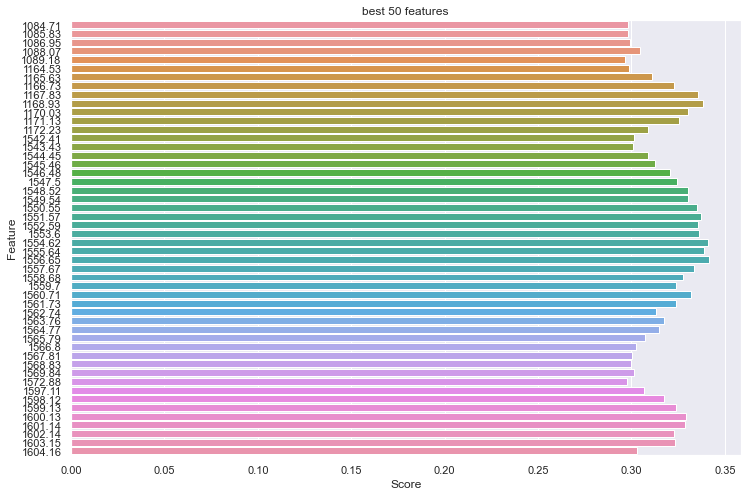

In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

def splitData(df, featureList, target):
    x = df.drop(featureList, axis=1)
    y = df[target]
    return x, y

def createEstimatorScoreDF(x, estimatorScore, sortedIdx):
    estimatorScoreDF = pd.DataFrame(estimatorScore[sortedIdx][::-1],
                                    index=x.columns[sortedIdx][::-1],
                                    columns=['score'])
    return estimatorScoreDF

def plotEstimatorScoreTopN(x, sortedIdx, estimatorScore, top_n, title):
    top_n_features = x.columns[sortedIdx[-top_n:]][::-1]
    top_n_scores = estimatorScore[sortedIdx[-top_n:]][::-1]

    fig, ax = plt.subplots(figsize=(12, 8))
    sns.barplot(x=top_n_scores, y=top_n_features, orient='h')
    ax.set(xlabel='Score', ylabel='Feature', title=title)
    plt.show()

def estimatorScoreTopN(x, y, top_n, title):
    estimatorScore = mutual_info_classif(x, y, random_state=42)
    sortedIdx = np.argsort(estimatorScore)
    estimatorScoreDF = createEstimatorScoreDF(x, estimatorScore, sortedIdx)
    plotEstimatorScoreTopN(x, sortedIdx, estimatorScore, top_n, title)
    return estimatorScoreDF

def selectKBestFeatures(k, estimatorScore, df):
    k_best = k
    k_best_features = estimatorScore.iloc[:k_best, :].index
    k_best_df = df[k_best_features]
    return k_best_df


#nWaves = 441
#nFeatures = 50

top_n = 50

X_sensor, y_sensor = splitData(X, ['target'], 'target')
estimator_scores_df = estimatorScoreTopN(X_sensor, y_sensor, top_n, f'best {top_n} features')

In [21]:
k_best_df = selectKBestFeatures(top_n, estimator_scores_df, X)
k_best_df['target'] = X['target']
k_best_df


C:\Users\Lucas\AppData\Local\Temp\ipykernel_19012\27589359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_best_df['target'] = X['target']


,1556.65,1554.62,1555.64,1168.93,1551.57,1553.6,1552.59,1167.83,1550.55,1557.67,...,1543.43,1567.81,1568.83,1086.95,1164.53,1084.71,1085.83,1572.88,1089.18,target
0,2441.59,2297.86,2330.34,1711.22,2323.43,2309.67,2328.85,1669.89,2300.82,2351.02,...,2238.48,2691.57,2687.21,3545.22,1534.65,4800.88,4170.96,2862.39,2657.88,1
1,2384.98,2354.44,2303.27,1749.91,2320.98,2282.61,2350.98,1744.97,2325.40,2424.88,...,2307.21,2728.58,2714.35,3558.65,1568.75,4890.36,4341.02,3017.98,2872.84,1
2,2372.67,2408.57,2404.16,1745.36,2281.64,2304.75,2314.09,1678.99,2288.53,2474.11,...,2304.76,2661.97,2724.22,3717.56,1602.85,4910.50,4327.59,2916.72,2772.08,1
3,2394.83,2339.68,2369.71,1722.60,2392.28,2412.97,2375.57,1688.09,2288.53,2434.73,...,2302.30,2679.23,2805.65,3675.03,1593.76,4863.52,4316.40,2948.83,2751.93,1
4,2340.68,2420.87,2431.23,1811.35,2360.31,2292.45,2368.19,1749.52,2271.32,2432.26,...,2250.76,2652.10,2647.73,3717.56,1568.75,4961.95,4327.59,2961.18,2742.97,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15871,2781.25,2861.25,2879.08,2216.40,2734.03,2791.77,2744.45,2159.03,2792.44,2956.63,...,2606.66,3308.34,3402.81,4653.10,1905.23,5874.70,5260.68,3605.77,3331.87,0
15872,2845.24,2812.05,2916.00,2161.79,2670.10,2868.02,2773.96,2072.58,2716.24,2939.40,...,2609.11,3468.70,3383.07,4646.39,1932.52,5852.33,5238.31,3726.79,3396.81,0
15873,2835.40,2804.66,2812.64,2298.32,2793.04,2745.03,2788.71,2149.93,2745.74,2927.09,...,2506.02,3485.97,3471.90,4718.01,1950.70,6111.84,5274.11,3707.03,3419.20,0
15874,2877.24,2743.16,2970.13,2257.36,2839.75,2828.66,2914.13,2170.41,2743.28,3013.25,...,2672.93,3485.97,3452.16,4655.34,2003.00,6002.22,5318.86,3734.20,3358.74,0


In [22]:
def pairPlot(data, hue):
    plot = sns.PairGrid(data, hue= hue, diag_sharey=False, corner=True)
    plot.map_lower(sns.scatterplot)
    plot.map_diag(sns.histplot)
    plot.add_legend(title="pair plot of the best features")
    plt.show()

#pairPlot(k_best_df, 'target')

In [23]:
def correlationPlot(data):
    fig, ax = plt.subplots(figsize=(30, 30))
    corrMatrix = data.corr(method = 'pearson')
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corrMatrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                fmt = '.2f', annot = True)

    plt.show()


#correlationPlot(k_best_df)

In [24]:
def boxPlots(df):
    figsize = (15,12)
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    sns.boxplot(data = df)
    plt.xticks(rotation = 60, fontsize = 10)
    plt.show()

X = k_best_df.iloc[:,:-1]
#boxPlots(X)

In [25]:
def groupMaps(df):
    # Group the data by the "map" and "target" columns and calculate the sum of each group divided by 441
    grouped_df = df.groupby(['map', 'target']).sum() / 441

    # Reset the index of the grouped DataFrame to make "map" a regular column
    grouped_df = grouped_df.reset_index()

    return grouped_df

X = raw_data.drop(['x','y','spec_number'], axis = 1)
map_data = groupMaps(X)
map_data.head()

,map,target,1611.19,1610.19,1609.18,1608.18,1607.17,1606.17,1605.16,1604.16,...,482.426,481.162,479.898,478.634,477.37,476.105,474.84,473.574,472.308,471.042
0,0,0,2742.105873,2798.736417,2874.096327,2950.670726,3054.272971,3180.465147,3324.720113,3515.356236,...,1345.552880,1345.467937,1345.150385,1343.396825,1345.594762,1348.853515,1342.911315,1347.481995,1348.807234,1347.423265
1,0,1,2056.205556,2085.446553,2125.698594,2172.269184,2234.672086,2302.389796,2392.515193,2499.599093,...,862.485594,863.278281,864.007422,864.938204,865.177950,867.447941,862.901399,870.519655,869.141009,869.289891
2,1,0,2698.916100,2743.951814,2808.769909,2872.453424,2957.524376,3063.940499,3198.414785,3355.753651,...,1256.731406,1259.064739,1257.529524,1258.112290,1260.138005,1264.314150,1259.674535,1265.465964,1266.386372,1265.559819
3,1,1,1977.836304,2004.130567,2047.413991,2091.355102,2139.875261,2209.508435,2283.847823,2385.656077,...,798.014070,794.654417,796.593617,796.975764,799.020998,798.147435,799.564145,803.246866,803.134297,803.957599
4,2,0,2665.994331,2702.568050,2762.823832,2833.576395,2908.377415,3014.860227,3144.365737,3302.443991,...,1217.169388,1214.146440,1216.139433,1218.826621,1220.749524,1220.973560,1218.777483,1223.835374,1224.201519,1223.228549


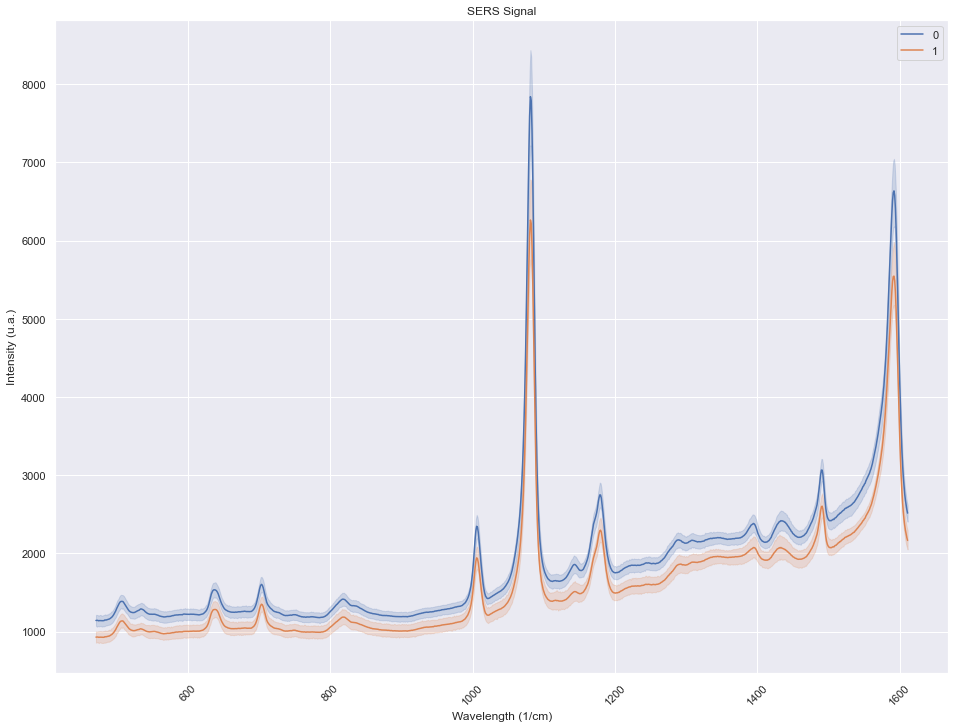

In [26]:

def plotSersSignal(dataframe):
    sns.set(style="darkgrid")
    fig, ax = plt.subplots(figsize=(16,12))

    target_column = "target"
    columns = dataframe.columns.to_list()
    columns.remove(target_column)

    dataframe_melted = dataframe.melt(id_vars=target_column, value_vars=columns, var_name="Wavelength (1/cm)", value_name="Intensity (u.a.)")
    sns.lineplot(data=dataframe_melted, x="Wavelength (1/cm)", y="Intensity (u.a.)", hue=target_column, markers=True)

    plt.xlabel('Wavelength (1/cm)')
    plt.ylabel('Intensity (u.a.)')
    plt.title('SERS Signal')
    plt.legend()
    plt.xticks(rotation=45)  # Set x-axis ticks to go from 50 to 50 values
    #plt.tight_layout()
    plt.show()


X2 = map_data.drop(['map'], axis = 1)
plotSersSignal(X2)


# Clustering

c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

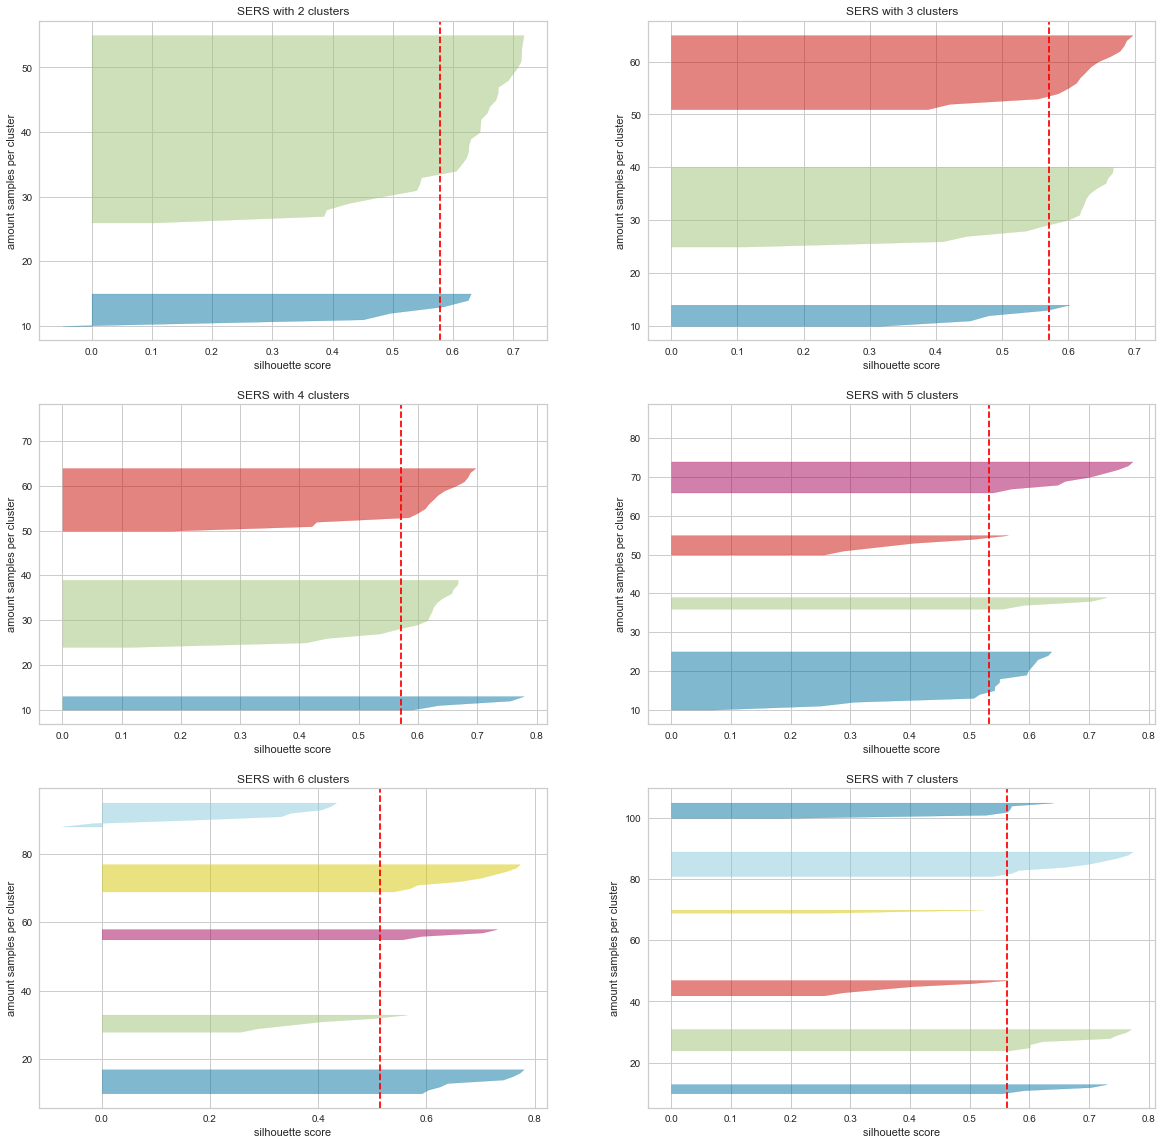

In [27]:
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import cosine

def plotSilhoetteVisualizer(X, Ks, title):
    fig, ax = plt.subplots(3, 2, figsize = (20, 20))

    silhouette_coef_list = []
    for k in Ks:
        np.random.seed(42)
        km_model = KMeans(n_clusters = k)
        q, mod = divmod(k,2)
        dist_matrix = pairwise_distances(X, metric='cosine')

        visualizer = SilhouetteVisualizer(km_model, colors = 'yellowbrick', ax = ax[q-1][mod])

        ax[q-1][mod].set(title = f'{title} with {k} clusters', 
                         xlabel = 'silhouette score', 
                         ylabel = 'amount samples per cluster')
        
        visualizer.fit(dist_matrix)
        #print(f"{sensorName}: the silhouette's score for {k} clusters is {visualizer.silhouette_score_}")
        silhouette_coef_list.append(visualizer.silhouette_score_)
    plt.show()
    return silhouette_coef_list

## tentar fazer isso com mapas ao inves de espectros

Ks = [2,3,4,5,6,7]
X = raw_data.drop(['x','y','spec_number','map', 'target'], axis = 1)
#X2 = X2.drop(['target'], axis = 1)
raw_silhouette_scores = plotSilhoetteVisualizer(X2, Ks, 'SERS')

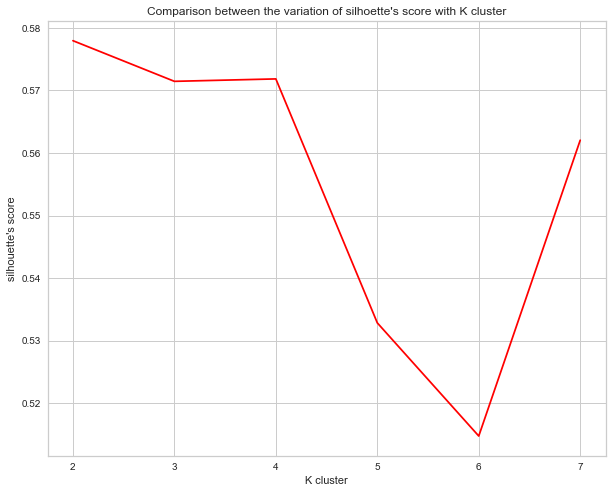

In [28]:
def plot_silhouette_score(silhouette_scores, Ks):
    fig, ax = plt.subplots(1, 1, figsize = (10, 8))
    sns.lineplot(x=Ks, y = silhouette_scores, color = 'red', ax=ax)
    ax.set(title = "Comparison between the variation of silhoette's score with K cluster",
           xlabel = 'K cluster',
           ylabel = "silhouette's score"
    )

    plt.show()

plot_silhouette_score(raw_silhouette_scores, Ks)


# Classification

In [29]:
from sklearn.linear_model import LogisticRegression
import time

from sklearn.svm import SVC
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

def mergeDataframes(df1, df2):
    mergedDf = pd.concat([df1, df2], axis = 1)
    return mergedDf

def separateFeatures(X, catVariables):
    numVariables = X.drop(catVariables, axis = 1).columns
    return catVariables, numVariables

def removeUselessColumns(df, columns):
    new_df = df.drop(columns, axis = 1)
    return new_df


def createBaselineModels(preprocessor, red_dim = None):
    if red_dim == None:
        pipe_rf = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('model', RandomForestClassifier())
        ])


        pipe_lr = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('model', LogisticRegression())
        ])

        pipe_knn = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('model', KNeighborsClassifier())
        ])


        pipe_xgboost = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('model', XGBClassifier())
        ])

        pipe_svm = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('model', SVC())
        ])

        pipe_nb = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('model', GaussianNB())
        ])

        pipe_dt = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('model', DecisionTreeClassifier())
        ])

    else:
        pipe_rf = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('red_dim', red_dim),
                ('model', RandomForestClassifier())
        ])

        pipe_lr = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('red_dim', red_dim),
                ('model', LogisticRegression())
        ])

        pipe_knn = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('red_dim', red_dim),
                ('model', KNeighborsClassifier())
        ])


        pipe_xgboost = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('red_dim', red_dim),
                ('model', XGBClassifier())
        ])

        pipe_svm = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('red_dim', red_dim),
                ('model', SVC())
        ])

        pipe_nb = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('red_dim', red_dim),
                ('model', GaussianNB())
        ])

        pipe_dt = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('red_dim', red_dim),
                ('model', DecisionTreeClassifier())
        ])

    baseline_models = {
        'Logistic Regression': pipe_lr,
        'Random Forest': pipe_rf,
        'KNN': pipe_knn,
        'XGBoost': pipe_xgboost,
        'Suport Vector Machine': pipe_svm,
        'Naive Bayes': pipe_nb,
        'Decision Tree': pipe_dt
    }

    return baseline_models

def createGridModels(modelsPipeline, red_dim = None):
    pipe_rf, pipe_lr, pipe_knn, pipe_xgb, pipe_svm, pipe_nb, pipe_dt = modelsPipeline

    if red_dim != None:
        param_grid_rf = {
            'red_dim': [red_dim],
            'model__n_estimators':[100, 300, 500],
            'model__max_depth':[10, 50, 100],
            #'model__max_features': [3, 6, 9]
            #'model__max_features':[6,8,10,12,14,16]
            #'model__min_samples_split':[6],
            #'model__min_samples_leaf':[2, 4]
        }
        param_grid_lr = {
            'red_dim': [red_dim],
            'model__C': np.logspace(-4, 4, 20),
            'model__solver': ['liblinear'],
            'model__penalty': ['l1', 'l2']
        }
        param_grid_knn = {
            'red_dim': [red_dim],
            "model__n_neighbors": [1, 3, 5, 7, 10],
            'model__metric': ['minkowski','euclidean','manhattan'],
            'model__weights': ['uniform','distance'],
            #'model__max_iter': [50, 100, 150]
        }
        param_grid_xgb = {
            'red_dim': [red_dim],
            'model__n_estimators': [100, 500, 100],
            'model__max_depth': [3,4,5],
            'model__learning_rate': [0.01, 0.001]
        }
        param_grid_svm = {
            'red_dim': [red_dim],
            'model__C': [0.1, 1, 10, 100],
            'model__gamma': [1,0.1,0.01,0.001],
            'model__kernel': ['rbf', 'poly', 'sigmoid']
        }
        param_grid_nb = {
            'red_dim': [red_dim],
            'model__var_smoothing': np.logspace(0,-9, num=100)
        }

        param_grid_dt = {
            'red_dim': [red_dim],
            'model__max_depth': [2, 3, 5, 10, 20],
            'model__min_samples_leaf': [5, 10, 20, 50, 100],
            'model__criterion': ["gini", "entropy"]
        }

    else:
        param_grid_rf = {
            #'red_dim': [red_dim],
            'model__n_estimators':[100, 300, 500],
            'model__max_depth':[10, 50, 100],
            #'model__max_features': [3, 6, 9]
            #'model__max_features':[6,8,10,12,14,16]
            #'model__min_samples_split':[6],
            #'model__min_samples_leaf':[2, 4]
        }
        param_grid_lr = {
            #'red_dim': [red_dim],
            'model__C': np.logspace(-4, 4, 20),
            'model__solver': ['liblinear'],
            'model__penalty': ['l1', 'l2']
        }
        param_grid_knn = {
            #'red_dim': [red_dim],
            "model__n_neighbors": [1, 3, 5, 7, 10],
            'model__metric': ['minkowski','euclidean','manhattan'],
            'model__weights': ['uniform','distance'],
            #'model__max_iter': [50, 100, 150]
        }
        param_grid_xgb = {
            #'red_dim': [red_dim],
            'model__n_estimators': [100, 500, 100],
            'model__max_depth': [3,4,5],
            'model__learning_rate': [0.01, 0.001]
        }
        param_grid_svm = {
            #'red_dim': [red_dim],
            'model__C': [0.1, 1, 10, 100],
            'model__gamma': [1,0.1,0.01,0.001],
            'model__kernel': ['rbf', 'poly', 'sigmoid']
        }
        param_grid_nb = {
            #'red_dim': [red_dim],
            'model__var_smoothing': np.logspace(0,-9, num=100)
        }

        param_grid_dt = {
            #'red_dim': [red_dim],
            'model__max_depth': [2, 3, 5, 10, 20],
            'model__min_samples_leaf': [5, 10, 20, 50, 100],
            'model__criterion': ["gini", "entropy"]
        }


    rf = GridSearchCV(pipe_rf, param_grid_rf, n_jobs = -1)
    lr = GridSearchCV(pipe_lr, param_grid_lr, n_jobs = -1)
    knn = GridSearchCV(pipe_knn, param_grid_knn, n_jobs = -1)
    xgb = GridSearchCV(pipe_xgb, param_grid_xgb, n_jobs = -1)
    svm = GridSearchCV(pipe_svm, param_grid_svm, n_jobs = -1)
    nb = GridSearchCV(pipe_nb, param_grid_nb, n_jobs = -1)
    dt = GridSearchCV(pipe_dt, param_grid_dt, n_jobs = -1)

    grid_models = {
        'Logistic Regression': lr,
        'Random Forest': rf,
        'KNN': knn,
        'XGBoost': xgb,
        'Support Vector Machine': svm,
        'Gausian Naive Bayes': nb,
        'Decision Tree': dt
    }
    return grid_models



def createModels(preprocessor, withGrid, red_dim = None):
    np.random.seed(42)

    modelsPipeline = createBaselineModels(preprocessor, red_dim)

    if withGrid:
        modelsGrid = createGridModels(modelsPipeline, red_dim)
        return modelsGrid

    return modelsPipeline

        


def preprocessingData(cat_features, num_features, scaler, encoder):
    ## Tratamento para variáveis categóricas
    cat_transformer = Pipeline(steps = [
        ('encoder', encoder)
    ])

    ## Tratamento para variáveis numéricas
    num_transformer = Pipeline(steps = [
        ('scaler', scaler)
    ])

    ## Transformando os dados
    preprocessor = ColumnTransformer(transformers = [
        ('numbers', num_transformer, num_features),
        ('categories', cat_transformer, cat_features)
    ])

    ## Retornando o processador de dados
    return preprocessor

def format_metrics(scores):
    avg = round(np.mean(scores), 2)
    std = round(np.std(scores), 2)
    return f'{str(avg)} ({str(std)})'

def trainModels(X, y, models, skf):
    scoring = ('accuracy', 'precision', 'recall', 'f1')
    models_scores = {}

    for modelName, model in models.items():
        startTime = time.time()
        scores = cross_validate(model, X, y, cv=skf, scoring=scoring)

        cross_metrics = {
            'accuracy': format_metrics(scores['test_accuracy']),
            'precision': format_metrics(scores['test_precision']),
            'recall': format_metrics(scores['test_recall']),
            'f1': format_metrics(scores['test_f1'])
        }

        models_scores[modelName] = cross_metrics

        endTime = time.time()
        print(f'{modelName}: {round(endTime - startTime, 2)} seconds')

    return models_scores


def runModels(X, y, catFeatures, numFeatures, scaler, encoder, withGrid=False, redDim=None):
    preprocessor = preprocessingData(cat_features=catFeatures, num_features=numFeatures, scaler=scaler, encoder=encoder)
    models = createModels(preprocessor, withGrid, redDim)
    skf = StratifiedKFold(n_splits=10)
    models_scores = trainModels(X, y, models, skf)
    
    models_scores = pd.DataFrame(models_scores)
    models_acc = models_scores.loc['accuracy'].values
    models_names = models.keys()
    return models_acc, models_scores, models_names


def dataPipeline(data, noUsedColumns = ['x','y', 'spec_number', 'map','target']):

    #print(f'---{dataName} started---', end='\n\n')
    startTime = time.time()
    new_data = data.copy()
    X, y = splitData(data, noUsedColumns, 'target')
    catFeatures, numFeatures = separateFeatures(X, [])
    models_acc, models_metrics, models_names = runModels(
        X, y, catFeatures, numFeatures, StandardScaler(), OneHotEncoder(handle_unknown='ignore')
    )

    endTime = time.time()
    #print(f'\n---{dataName}: completed in {round(endTime - startTime, 2)} seconds---', end='\n\n')

    models_acc = pd.DataFrame(models_acc, index=models_names)
    return models_acc, models_metrics.T

def convertComplexToReal(df):
    for column in df.columns:
        if df[column].dtype == np.complex128:
            df[column] = df[column].apply(lambda x: x.real)
    return df


def treatFFTData(dfs):
    newFFT = {}
    for dfName, df in dfs.items():
        new_df = df.iloc[:,:-1].copy()
        new_df = convertComplexToReal(new_df)
        newFFT[dfName] = new_df
        newFFT[dfName]['target'] = df['target']
    return newFFT


In [30]:
raw_data.columns

Index([      1611.19,       1610.19,       1609.18,       1608.18,
             1607.17,       1606.17,       1605.16,       1604.16,
             1603.15,       1602.14,
       ...
             476.105,        474.84,       473.574,       472.308,
             471.042,           'x',           'y', 'spec_number',
               'map',      'target'],
      dtype='object', length=1019)

In [31]:
raw_acc, raw_metrics = dataPipeline(X2, noUsedColumns=['target'])
raw_metrics

Logistic Regression: 0.92 seconds
Random Forest: 2.51 seconds
KNN: 0.4 seconds
XGBoost: 2.82 seconds


c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Suport Vector Machine: 0.49 seconds
Naive Bayes: 0.45 seconds
Decision Tree: 0.53 seconds


c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,precision,recall,f1
Logistic Regression,0.9 (0.17),0.92 (0.17),0.95 (0.15),0.91 (0.14)
Random Forest,0.84 (0.17),0.9 (0.2),0.85 (0.23),0.83 (0.17)
KNN,0.72 (0.31),0.73 (0.35),0.8 (0.33),0.72 (0.3)
XGBoost,0.82 (0.3),0.82 (0.32),0.85 (0.32),0.81 (0.3)
Suport Vector Machine,0.75 (0.4),0.7 (0.46),0.7 (0.46),0.7 (0.46)
Naive Bayes,0.75 (0.39),0.77 (0.4),0.75 (0.4),0.75 (0.39)
Decision Tree,0.79 (0.19),0.77 (0.33),0.8 (0.33),0.75 (0.29)


In [32]:
raw_acc

,0
Logistic Regression,0.9 (0.17)
Random Forest,0.84 (0.17)
KNN,0.72 (0.31)
XGBoost,0.82 (0.3)
Suport Vector Machine,0.75 (0.4)
Naive Bayes,0.75 (0.39)
Decision Tree,0.79 (0.19)


In [36]:
X2.columns

Index(['target',  1611.19,  1610.19,  1609.18,  1608.18,  1607.17,  1606.17,
        1605.16,  1604.16,  1603.15,
       ...
        482.426,  481.162,  479.898,  478.634,   477.37,  476.105,   474.84,
        473.574,  472.308,  471.042],
      dtype='object', length=1015)

# PCA

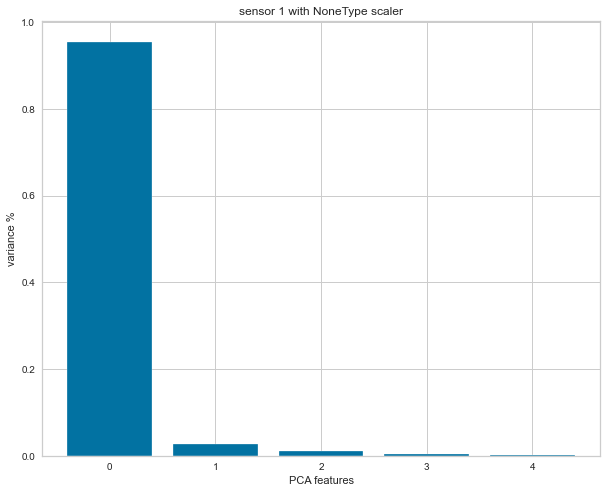

In [80]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


def calculate_pca(df, n_components=None, scaler=None):
    X = df.drop(['target'], axis=1)

    if scaler is not None:
        X = scaler.fit_transform(X)

    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X)

    new_df = pd.DataFrame(principal_components)
    new_df['target'] = df['target'].values

    return pca, new_df


def plot_pca_variance(pca, name_sensor, scaler_name=None):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    features = np.arange(pca.n_components_)
    ax.bar(features, pca.explained_variance_ratio_)
    ax.set(xlabel='PCA features', ylabel='variance %', xticks=features,
           title=f'{name_sensor} with {scaler_name} scaler')
    plt.show()


def calculating_pca(df, name_sensor, n_components, scaler=None):
    pca, new_df = calculate_pca(df, n_components, scaler)
    plot_pca_variance(pca, name_sensor, scaler.__class__.__name__)

    return new_df


PCA_components = calculating_pca(X2, 'sensor 1', 5)


In [81]:
#PCA_components

In [86]:
from scipy.spatial import Voronoi, voronoi_plot_2d

def convertColsNameToStr(df):
    """
    Convert column names in a Pandas DataFrame to string data type.
    """
    df.columns = df.columns.astype(str)
    return df

def writeInPlot(df, ax):
    for i in range(len(df)):
        name = 'positive' if df['target'][i] == 1 else 'negative'
        ax.text(x = df.loc[i, 0], y = df.loc[i,1], s = name)


def plotPCA(df, title, ax, target = 'target', palette = ['red', 'blue']):
    
    sns.scatterplot(data = df, x = 0, y = 1, hue = target, palette = palette, ax = ax)
    ax.set(xlabel = 'PC1', ylabel = 'PC2', title = title)
    #writeInPlot(df, ax)

def plotDecisionBoundaries(df, target, labels, centroids, title, ax):

    new_df = df.copy()
    new_df = convertColsNameToStr(new_df)
    
    vor = Voronoi(centroids)

    # Plot the Voronoi diagram and the data points colored by target
    fig = voronoi_plot_2d(vor, show_vertices=False, ax = ax)
    sns.scatterplot(data = new_df, x = '0', y = '1', hue = target, ax = ax)

    # Plot the cluster centroids as black X's
    sns.scatterplot(x = centroids[:, 0], y = centroids[:, 1], marker='x', s=150, linewidths=3, color='black', ax = ax)

    # Set the title and axis labels
    ax.set(title = title,
            xlabel = 'PC1',
            ylabel = 'PC2')

    #plt.legend()
    # Show the plot
    #plt.show()
    


# plotPCA(df = PCA_components, 
#         title = 'sensor 1', 
#         )

c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

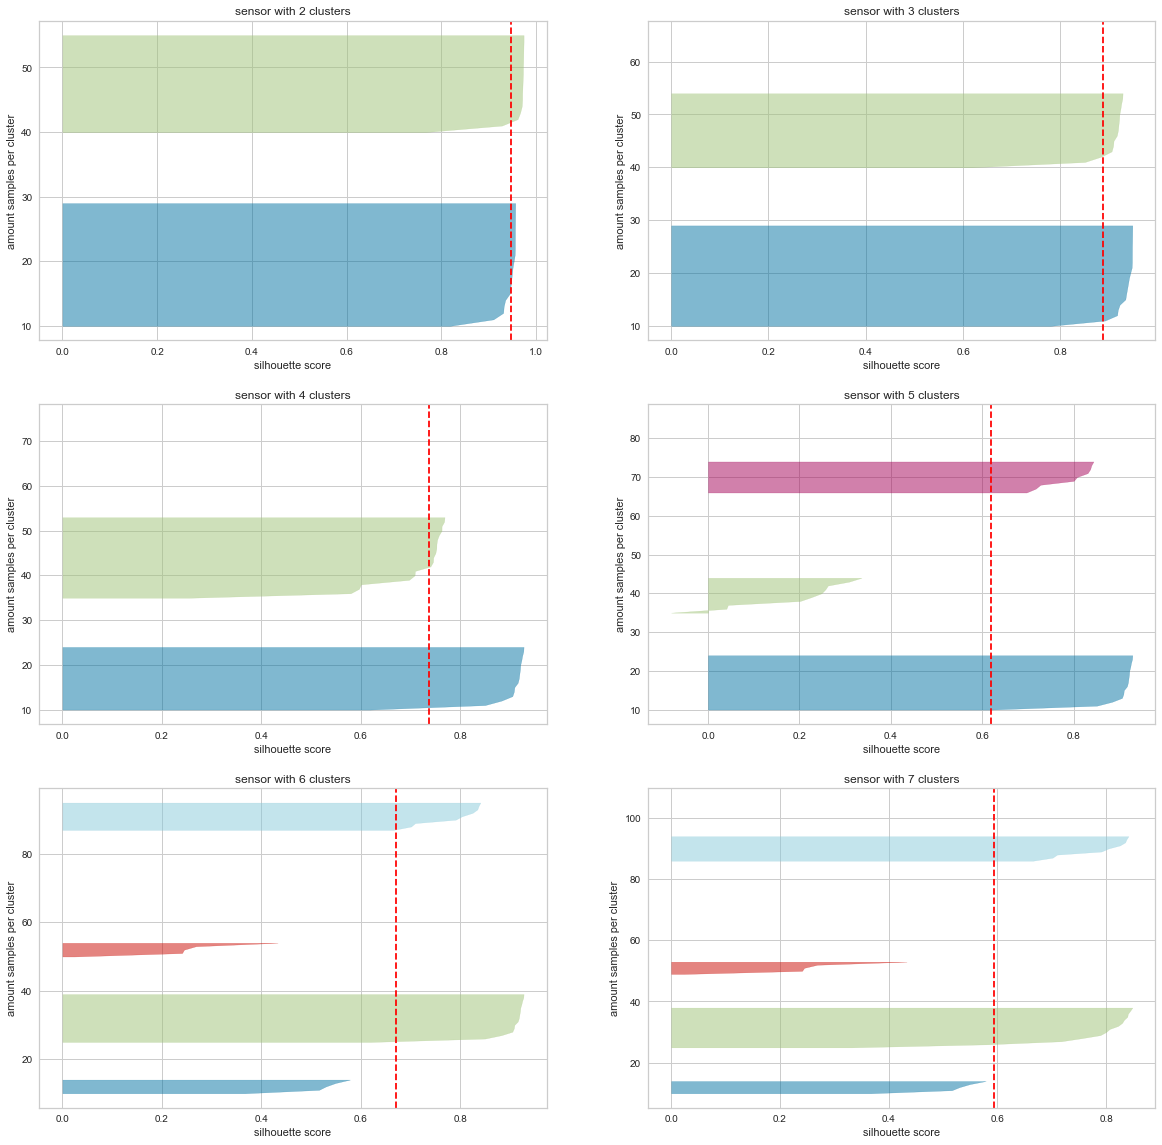

In [83]:
Ks = [2,3,4,5,6,7]
pca_silhouette_scores = plotSilhoetteVisualizer(X = PCA_components.iloc[:,:-1], 
                                                Ks = Ks, 
                                                title='sensor')



## Cluster Analysis

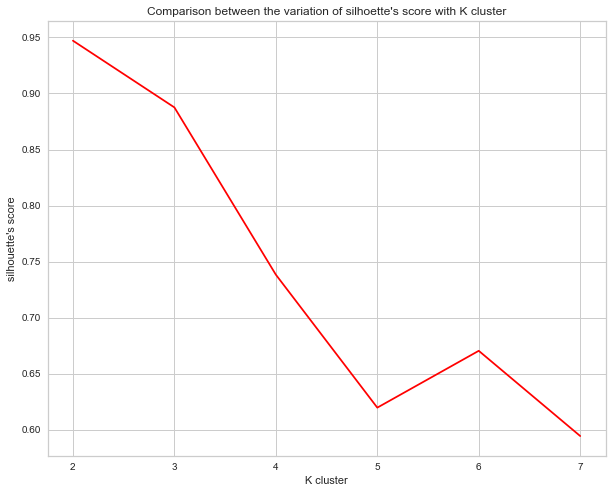

In [84]:

def plot_silhouette_score(silhouette_scores, Ks):
    fig, ax = plt.subplots(1, 1, figsize = (10, 8))
    sns.lineplot(x=Ks, y = silhouette_scores, color = 'red', ax=ax)
    ax.set(title = "Comparison between the variation of silhoette's score with K cluster",
           xlabel = 'K cluster',
           ylabel = "silhouette's score"
    )

    plt.show()

plot_silhouette_score(pca_silhouette_scores, Ks)

c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


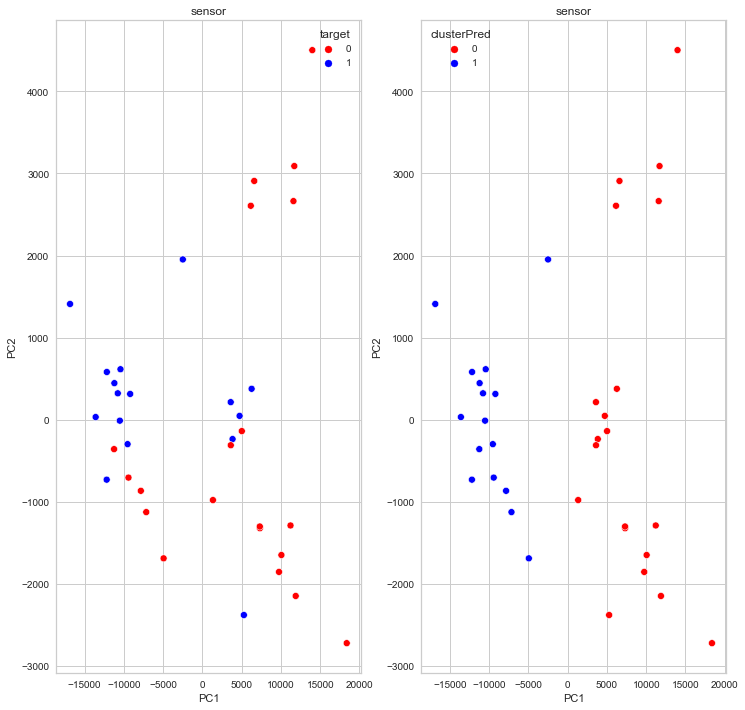

In [88]:
def clusterPreds(X, k):
    #print(X.columns, k)
    kmeans = KMeans(n_clusters = k)
    cluster_pred = kmeans.fit_predict(X)
    centroids = kmeans.cluster_centers_
    return cluster_pred, centroids

def getMaxSilhouetteScore(array):
    return max(array)

def getIndexArray(array, value):
    return array.index(value)

def getBestK(array, Ks):
    max_silhouette = getMaxSilhouetteScore(array)
    k_position = getIndexArray(array, max_silhouette)
    k = Ks[k_position]
    return k


best_K_sensor = getBestK(pca_silhouette_scores, Ks)
PCA_components['clusterPred'], pcaCentroidSensor = clusterPreds(
                                                    X = PCA_components.iloc[:, :2],
                                                    k = best_K_sensor
                                                )

fig, ax = plt.subplots(1,2, figsize = (12,12))


plotPCA(df = PCA_components, 
        title = 'sensor', 
        ax = ax[0]
        )

plotPCA(df = PCA_components,
        target = 'clusterPred',
        title = 'sensor', 
        ax = ax[1]
        )


# plotDecisionBoundaries(df = PCA_components,
#                        target = 'target',
#                        labels = PCA_components['clusterPred'],
#                        centroids = pcaCentroidSensor,
#                        title = f"{best_K_sensor} clusters in sensor",
#                        ax = ax[1])


# plt.show()

In [90]:
PCA_components.columns

Index([0, 1, 2, 3, 4, 'target', 'clusterPred'], dtype='object')

## Cluster classification

In [92]:
pca_acc, pca_metrics = dataPipeline(PCA_components, noUsedColumns=['target', 'clusterPred'])
pca_metrics

c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression: 0.23 seconds
Random Forest: 2.36 seconds
KNN: 0.25 seconds


c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


XGBoost: 0.42 seconds
Suport Vector Machine: 0.21 seconds
Naive Bayes: 0.22 seconds


c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decision Tree: 0.2 seconds


c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,precision,recall,f1
Logistic Regression,0.82 (0.23),0.75 (0.34),0.85 (0.32),0.78 (0.32)
Random Forest,0.88 (0.21),0.88 (0.24),0.95 (0.15),0.88 (0.18)
KNN,0.98 (0.08),1.0 (0.0),0.95 (0.15),0.97 (0.1)
XGBoost,0.75 (0.28),0.67 (0.42),0.7 (0.4),0.66 (0.39)
Suport Vector Machine,0.94 (0.12),0.95 (0.15),0.95 (0.15),0.93 (0.13)
Naive Bayes,0.84 (0.21),0.77 (0.33),0.9 (0.3),0.81 (0.3)
Decision Tree,0.78 (0.32),0.65 (0.45),0.7 (0.46),0.67 (0.45)


### Teste

NameError: name 'antigen' is not defined

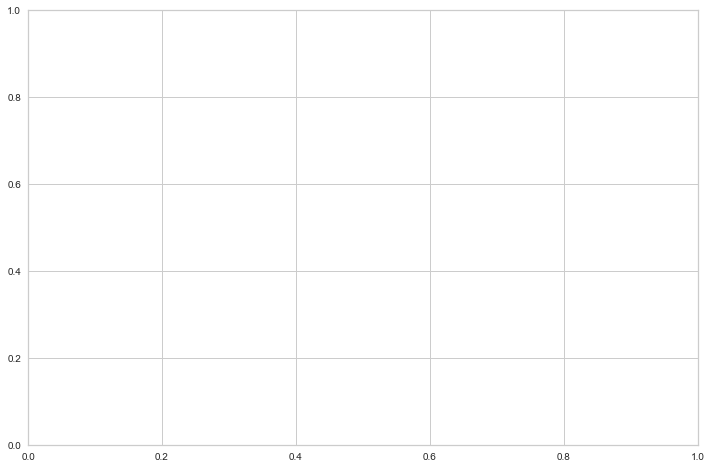

In [33]:
fig, ax = plt.subplots(1,1, figsize = (12,8))
antigenSpec = antigen[:1014]
controlSpec = control[:1014]
interferingSpec = interfering[:1014]

#spec2 = data[1014:2028]
plt.plot(antigenSpec[2], antigenSpec[3], '.r-', label = 'antigen')
plt.plot(controlSpec[2], controlSpec[3], '.g-', label = 'control')
plt.plot(interferingSpec[2], interferingSpec[3], '.b-', label = 'interfering')

#ax = plt.plot(spec2[2], spec2[3], '.b-')
ax.set(xlabel = 'comprimento da onda (1/cm)',
       ylabel = 'intensidade (u.a)',
       title = 'SERS')

plt.legend()
plt.show()

In [ ]:
# DataFrame de exemplo
data = {'Categoria': ['A', 'A', 'B', 'B', 'C', 'C'],
        'Valor': [10, 20, 30, 40, 50, 60]}
df = pd.DataFrame(data)

# Calcular a média dos valores para cada categoria
media_por_categoria = df.groupby('Categoria')['Valor'].mean()

print(media_por_categoria)


Categoria
A    15.0
B    35.0
C    55.0
Name: Valor, dtype: float64
